In [9]:
import subprocess as sp
import os
import numpy as np
from tqdm import tqdm
import shutil
from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.models import Config2D, StarDist2D
from csbdeep.utils import Path, normalize
from tifffile import imread
from glob import glob
from tracking_utils import plot_img_label, random_fliprot, random_intensity_change, augmenter
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR) # this goes *before* tf import
import tensorflow as tf
import matplotlib.pyplot as plt
from stardist import _draw_polygons
import pandas as pd

np.random.seed(42)
lbl_cmap = random_label_cmap()

In [2]:
def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

if 0:
    print(get_gpu_memory())
    from csbdeep.utils.tf import limit_gpu_memory
    limit_gpu_memory(fraction = 0.5, total_memory=5000)

In [3]:
train_verb = False
optimize_verb = False

In [4]:
model_name = 'modified_2D_versatile_fluo_1000x1000_v3'

X = sorted(glob("./simulation/synthetic_dataset_100_fps_r_decay_r_gaussian/image/*.tif"))
Y = sorted(glob("./simulation/synthetic_dataset_100_fps_r_decay_r_gaussian/mask/*.tif"))

if model_name == 'new':
    n_rays = 32
    use_gpu = True
    grid = (2, 2)
    conf = Config2D (
        n_rays       = n_rays,
        grid         = grid,
        use_gpu      = use_gpu,
        n_channel_in = n_channel,
    )
    model = StarDist2D(conf, name=f'stardist_trained_from_zero', basedir='models')
else:
    if 0:
        model_pretrained = StarDist2D.from_pretrained('2D_versatile_fluo')
        shutil.copytree(model_pretrained.logdir, f'./models/{model_name}')
        model = StarDist2D(None, f'./models/{model_name}')
    else:
        model = StarDist2D(None, name = f'{model_name}', basedir = 'models')

learning_rate = vars(model.config)['train_learning_rate']
print(model.config)

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.857627, nms_thresh=0.3.
Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=[3, 3], unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=[2, 2], unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=[None, None, 1], net_mask_shape=[None, None, 1], train_shape_completion=False, train_completion_crop=32, train_patch_size=[256, 256], train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=[1, 0.2], train_class_weights=(1, 1), train_epochs=800, train_steps_per_epoch=400, train_learni

In [5]:
if train_verb and optimize_verb:
    assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))
    X = list(map(imread,X))
    Y = list(map(imread,Y))
    n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
    axis_norm = (0,1)   # normalize channels independently
    # axis_norm = (0,1,2) # normalize channels jointly
    if n_channel > 1:
        print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
        sys.stdout.flush()

    X = [normalize(x, 1, 99.8, axis = axis_norm) for x in tqdm(X)]
    Y = [fill_label_holes(y) for y in tqdm(Y)]

    fig, ax = plt.subplots(2, 2, figsize = (10, 10))
    ax[0, 0].imshow(X[0])
    ax[0, 1].imshow(Y[0])
    ax[1, 0].imshow(X[-1])
    ax[1, 1].imshow(Y[-1])
    plt.savefig(f'./models/{model_name}/test.png', dpi = 500)
    plt.close()

    assert len(X) > 1, "not enough training data"
    rng = np.random.RandomState(42)
    ind = rng.permutation(len(X))
    n_val = max(1, int(round(0.15 * len(ind))))
    ind_train, ind_val = ind[:-n_val], ind[-n_val:]
    X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
    X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
    print('number of images: %3d' % len(X))
    print('- training:       %3d' % len(X_trn))
    print('- validation:     %3d' % len(X_val))

    median_size = calculate_extents(list(Y), np.median)
    fov = np.array(model._axes_tile_overlap('YX'))
    print(f"median object size:      {median_size}")
    print(f"network field of view :  {fov}")
    if any(median_size > fov):
        print("WARNING: median object size larger than field of view of the neural network.")

In [6]:
if train_verb: 
    model.train(X_trn, Y_trn, validation_data=(X_val, Y_val), augmenter=augmenter, epochs=150, steps_per_epoch=100)

if optimize_verb:
    model.optimize_thresholds(X_val, Y_val)

if train_verb and optimize_verb:
    img = X_val[0]
    label, details = model.predict_instances(img, predict_kwargs = {'verbose' : False})
    coord, points, prob = details['coord'], details['points'], details['prob']
    fig, (ax,ax1) = plt.subplots(1, 2, figsize = (10, 5), sharex=True, sharey=True)
    ax.imshow(img, cmap = 'gray')
    ax1.imshow(img, cmap = 'gray')
    _draw_polygons(coord, points, prob, show_dist=True)
    plt.savefig(f'./models/{model_name}/example_X_val[0]_{model_name}.pdf', format = 'pdf')
    plt.close()

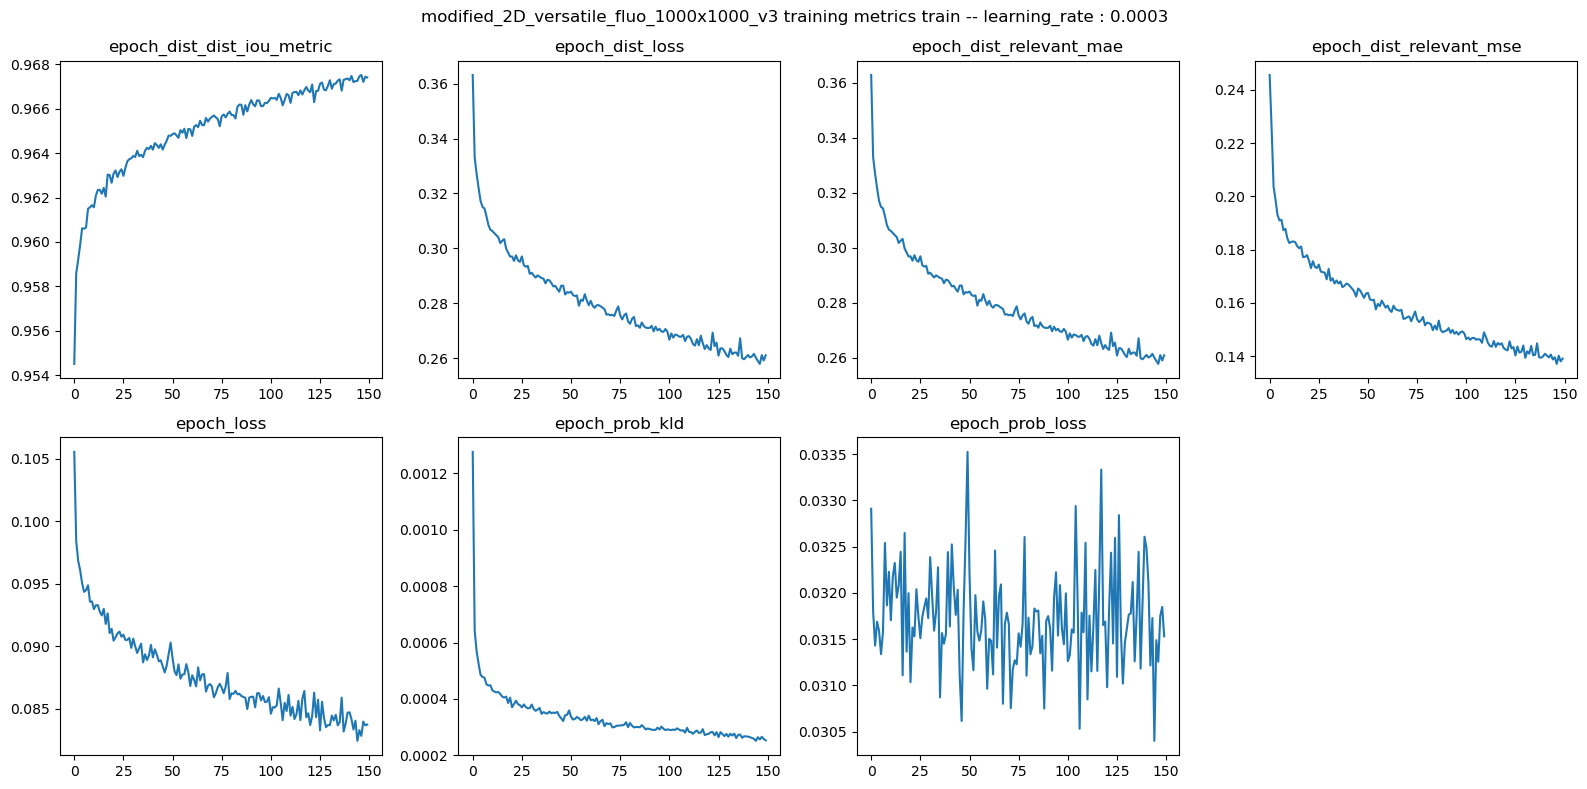

In [10]:
epoch_dist_dist_iou_metric_train = pd.read_csv(f'./models/{model_name}/logs_csv/epoch_dist_dist_iou_metric_train.csv')
epoch_dist_loss_train = pd.read_csv(f'./models/{model_name}/logs_csv/epoch_dist_loss_train.csv')
epoch_dist_relevant_mae_train = pd.read_csv(f'./models/{model_name}/logs_csv/epoch_dist_relevant_mae_train.csv')
epoch_dist_relevant_mse_train = pd.read_csv(f'./models/{model_name}/logs_csv/epoch_dist_relevant_mse_train.csv')
epoch_loss_train = pd.read_csv(f'./models/{model_name}/logs_csv/epoch_loss_train.csv')
epoch_prob_kld_train = pd.read_csv(f'./models/{model_name}/logs_csv/epoch_prob_kld_train.csv')
epoch_prob_loss_train = pd.read_csv(f'./models/{model_name}/logs_csv/epoch_prob_loss_train.csv')

fig, ax = plt.subplots(2, 4, figsize=(16, 8))
ax[0, 0].plot(epoch_dist_dist_iou_metric_train.Step, epoch_dist_dist_iou_metric_train.Value)
ax[0, 0].set_title('epoch_dist_dist_iou_metric')
ax[0, 1].plot(epoch_dist_loss_train.Step, epoch_dist_loss_train.Value)
ax[0, 1].set_title('epoch_dist_loss')
ax[0, 2].plot(epoch_dist_relevant_mae_train.Step, epoch_dist_relevant_mae_train.Value)
ax[0, 2].set_title('epoch_dist_relevant_mae')
ax[0, 3].plot(epoch_dist_relevant_mse_train.Step, epoch_dist_relevant_mse_train.Value)
ax[0, 3].set_title('epoch_dist_relevant_mse')
ax[1, 0].plot(epoch_loss_train.Step, epoch_loss_train.Value)
ax[1, 0].set_title('epoch_loss')
ax[1, 1].plot(epoch_prob_kld_train.Step, epoch_prob_kld_train.Value)
ax[1, 1].set_title('epoch_prob_kld')
ax[1, 2].plot(epoch_prob_loss_train.Step, epoch_prob_loss_train.Value)
ax[1, 2].set_title('epoch_prob_loss')
ax[1, 3].axis('off')
plt.suptitle(f'{model_name} training metrics train -- learning_rate : {learning_rate}')
plt.tight_layout()
plt.savefig(f'./models/{model_name}/training_metrics_train.png')
plt.show()

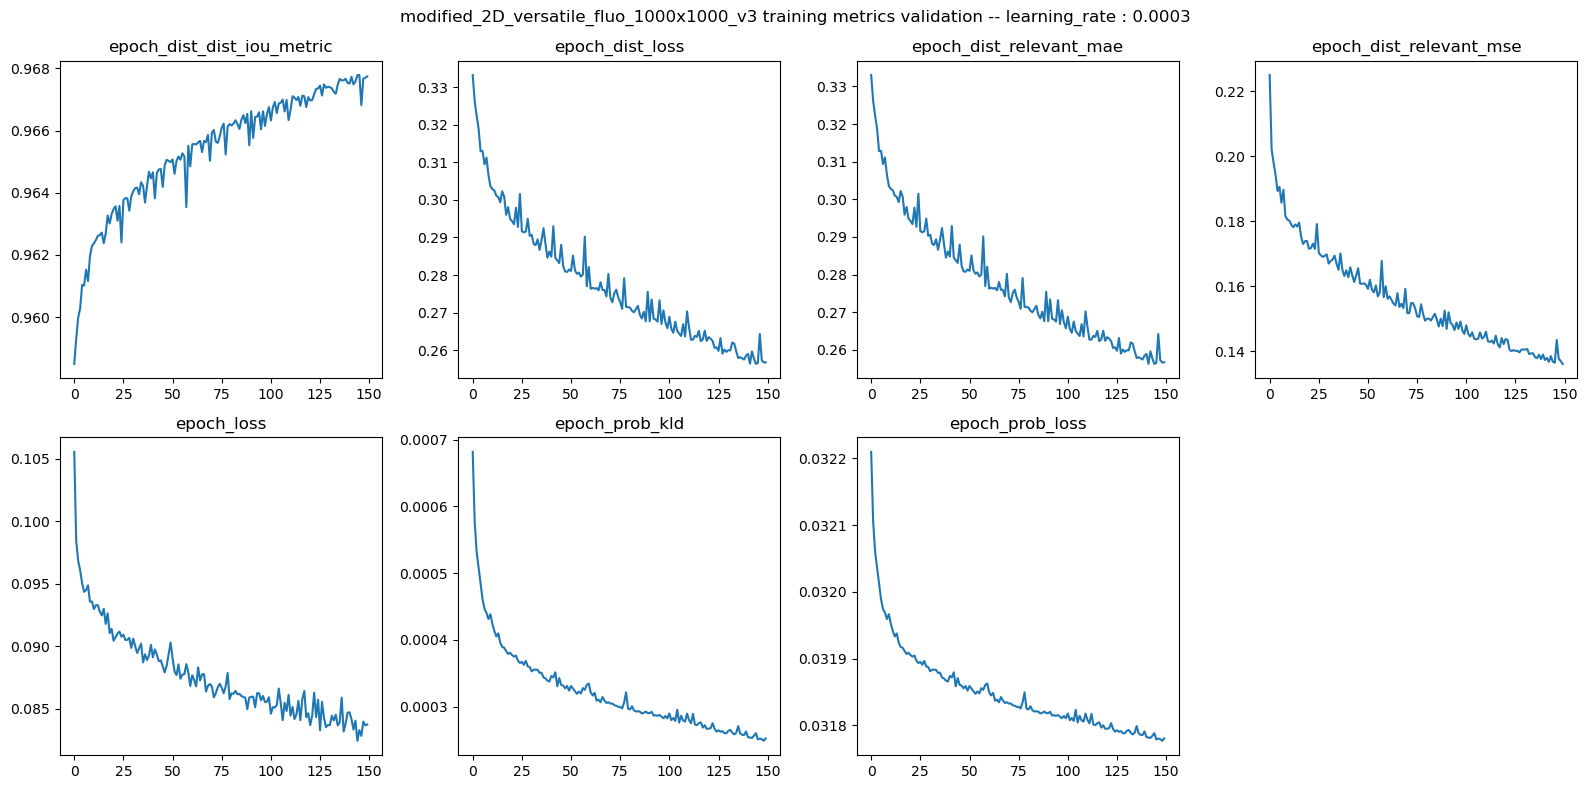

In [11]:
epoch_dist_relevant_mae_validation = pd.read_csv(f'./models/{model_name}/logs_csv/epoch_dist_relevant_mae_validation.csv')
epoch_dist_loss_validation = pd.read_csv(f'./models/{model_name}/logs_csv/epoch_dist_loss_validation.csv')
epoch_dist_dist_iou_metric_validation = pd.read_csv(f'./models/{model_name}/logs_csv/epoch_dist_dist_iou_metric_validation.csv')
epoch_loss_validation = pd.read_csv(f'./models/{model_name}/logs_csv/epoch_loss_train.csv')
epoch_dist_relevant_mse_validation = pd.read_csv(f'./models/{model_name}/logs_csv/epoch_dist_relevant_mse_validation.csv')
epoch_prob_kld_validation = pd.read_csv(f'./models/{model_name}/logs_csv/epoch_prob_kld_validation.csv')
epoch_prob_loss_validation = pd.read_csv(f'./models/{model_name}/logs_csv/epoch_prob_loss_validation.csv')


fig, ax = plt.subplots(2, 4, figsize=(16, 8))
ax[0, 0].plot(epoch_dist_dist_iou_metric_validation.Step, epoch_dist_dist_iou_metric_validation.Value)
ax[0, 0].set_title('epoch_dist_dist_iou_metric')
ax[0, 1].plot(epoch_dist_loss_validation.Step, epoch_dist_loss_validation.Value)
ax[0, 1].set_title('epoch_dist_loss')
ax[0, 2].plot(epoch_dist_relevant_mae_validation.Step, epoch_dist_relevant_mae_validation.Value)
ax[0, 2].set_title('epoch_dist_relevant_mae')
ax[0, 3].plot(epoch_dist_relevant_mse_validation.Step, epoch_dist_relevant_mse_validation.Value)
ax[0, 3].set_title('epoch_dist_relevant_mse')
ax[1, 0].plot(epoch_loss_validation.Step, epoch_loss_validation.Value)
ax[1, 0].set_title('epoch_loss')
ax[1, 1].plot(epoch_prob_kld_validation.Step, epoch_prob_kld_validation.Value)
ax[1, 1].set_title('epoch_prob_kld')
ax[1, 2].plot(epoch_prob_loss_validation.Step, epoch_prob_loss_validation.Value)
ax[1, 2].set_title('epoch_prob_loss')
ax[1, 3].axis('off')
plt.suptitle(f'{model_name} training metrics validation -- learning_rate : {learning_rate}')
plt.tight_layout()
plt.savefig(f'./models/{model_name}/training_metrics_validation.png')
plt.show()

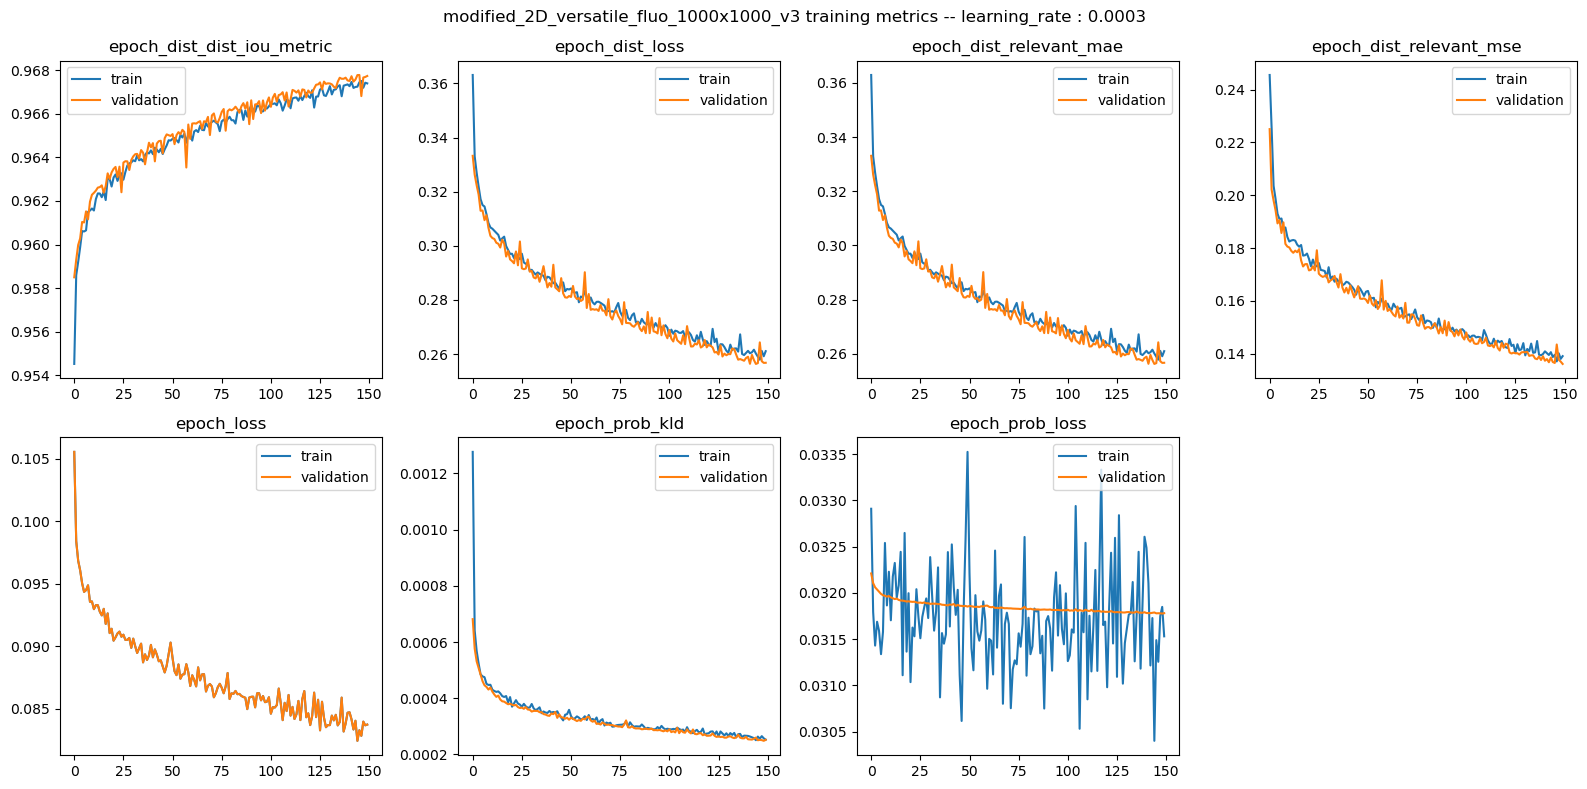

In [12]:
fig, ax = plt.subplots(2, 4, figsize=(16, 8))
ax[0, 0].plot(epoch_dist_dist_iou_metric_train.Step, epoch_dist_dist_iou_metric_train.Value, label = 'train')
ax[0, 0].plot(epoch_dist_dist_iou_metric_validation.Step, epoch_dist_dist_iou_metric_validation.Value, label = 'validation')
ax[0, 0].legend()
ax[0, 0].set_title('epoch_dist_dist_iou_metric')
ax[0, 1].plot(epoch_dist_loss_train.Step, epoch_dist_loss_train.Value, label = 'train')
ax[0, 1].plot(epoch_dist_loss_validation.Step, epoch_dist_loss_validation.Value, label = 'validation')
ax[0, 1].legend()
ax[0, 1].set_title('epoch_dist_loss')
ax[0, 2].plot(epoch_dist_relevant_mae_train.Step, epoch_dist_relevant_mae_train.Value, label = 'train')
ax[0, 2].plot(epoch_dist_relevant_mae_validation.Step, epoch_dist_relevant_mae_validation.Value, label = 'validation')
ax[0, 2].legend()
ax[0, 2].set_title('epoch_dist_relevant_mae')
ax[0, 3].plot(epoch_dist_relevant_mse_train.Step, epoch_dist_relevant_mse_train.Value, label = 'train')
ax[0, 3].plot(epoch_dist_relevant_mse_validation.Step, epoch_dist_relevant_mse_validation.Value, label = 'validation')
ax[0, 3].legend()
ax[0, 3].set_title('epoch_dist_relevant_mse')
ax[1, 0].plot(epoch_loss_train.Step, epoch_loss_train.Value, label = 'train')
ax[1, 0].plot(epoch_loss_validation.Step, epoch_loss_validation.Value, label = 'validation')
ax[1, 0].legend()
ax[1, 0].set_title('epoch_loss')
ax[1, 1].plot(epoch_prob_kld_train.Step, epoch_prob_kld_train.Value, label = 'train')
ax[1, 1].plot(epoch_prob_kld_validation.Step, epoch_prob_kld_validation.Value, label = 'validation')
ax[1, 1].legend()
ax[1, 1].set_title('epoch_prob_kld')
ax[1, 2].plot(epoch_prob_loss_train.Step, epoch_prob_loss_train.Value, label = 'train')
ax[1, 2].plot(epoch_prob_loss_validation.Step, epoch_prob_loss_validation.Value, label = 'validation')
ax[1, 2].legend()
ax[1, 2].set_title('epoch_prob_loss')
ax[1, 3].axis('off')
plt.suptitle(f'{model_name} training metrics -- learning_rate : {learning_rate}')
plt.tight_layout()
plt.savefig(f'./models/{model_name}/training_metrics.png')
plt.show()